# Mask R-CNN - Detection on Prostate Dataset


This notebook shows how to use trained Mask R-CNN on prostate dataset for a whole tile. As for large pathology image, we crop each image to several patches. This notebook is designed to get the detection reulst for single pic first and combine them back to the whole image. You'd need a GPU, though, because the network backbone is a Resnet101, which would be slow to detect on a CPU.

The code of the Prostate dataset can be found in prostate.py.

## Import Module

In [1]:
# import module from system lib
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import scipy.io

In [2]:
# import module from maskrcnn repo
from config import Config
import utils
import model as modellib
import visualize
from model import log
import prostate

%matplotlib inline

# Specify GPU to use
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

Using TensorFlow backend.


## Configurations

In [3]:
# Specify the dir that store the prostate dataset
dataset_dir = os.path.join(os.path.dirname(os.getcwd()), "Data_Pre_Processing/cedars-224")
# We do 5-fold validation, specify which fold to be exclude for the current run
held_out_set = 4
# Featch the mean_pixel based on the training data (data exclude the held_out_set)
mean_pixel = prostate.Mean_pixel(dataset_dir, held_out_set)
# Configuration
class DetectionConfig(prostate.ProstateConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.5
    DETECTION_NMS_THRESHOLD = 1     
    MEAN_PIXEL = np.array(mean_pixel)
    IMAGE_MAX_DIM = 512
    IMAGE_MIN_DIM = 512
    DETECTION_CROP = [128, 384, 128, 384] # [height_crop_start, height_crop_end, width_crop_start, width_crop_end]
    MODE = 16
detection_config = DetectionConfig()
detection_config.display()


Configurations:
BACKBONE_SHAPES                [[128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]
 [  8   8]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [ 0.1  0.1  0.2  0.2]
DETECTION_CROP                 [128, 384, 128, 384]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.5
DETECTION_NMS_THRESHOLD        1
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  512
IMAGE_MIN_DIM                  512
IMAGE_PADDING                  True
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [ 193.97800579  120.89113632  183.79060979]
MINI_MASK_SHAPE                (56, 56)
MODE                           16
NAME                           prostate
NUM_CLASSES       

## Create Model Graph and Loading Weights

In [4]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="detection", 
                          config=detection_config,
                          model_dir=MODEL_DIR)
# Get path to saved weights
# Either set a specific path, find a trained weights specified by epoch and held_out_set or find last trained weights
h5_filename = None # Specify the h5 filename here if you want to choose a specific file
epoch = -1

if h5_filename is not None:
    model_path = os.path.join(ROOT_DIR, ".h5 file name here")
elif epoch == -1:    
    model_path = model.find_last()[1]
else:
    try:
        model_path = model.find_specific(epoch = epoch, held_out_set = held_out_set)[1]
    except:
        model_path = model.find_specific(epoch = epoch)[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /scratch/wenyuan/Mask_RCNN_On_Pathology/Mask_RCNN/logs/prostate20180223T1554-held-out-4/mask_rcnn_prostate_0071.h5


## Prepare the Dataset and Specify the Interested Image

In [23]:
Random = False # whether to randomly choose the image
# Specify the image that is interested in
val_list = [139]
# val_list = [image for image in val_list if image not in exclude_list]
if Random:
    _, val_list = dataset_val.generator_patition(dataset_dir, held_out_set)    
    image_id = random.choice(val_list)
    val_list = [image_id]
    image_patch_num = np.random.randint(0, detection_config.MODE)

dataset_val = prostate.ProstateDataset()
dataset_val.load_prostate(dataset_dir, val_list, mode = detection_config.MODE)
dataset_val.prepare()

## Run Detection

In [24]:
image_whole = []
gt_mask_whole = []
det_mask_whole = []
det_probs_whole = []
hv, wv = utils.create_crop_region(detection_config) # meshgrid for crop region
for i in range(detection_config.MODE):
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, detection_config,
                               i, use_mini_mask=False)
    gt_tumor_class = 1 if (sum(gt_class_id)) else 0
    
    image_whole.append(image[hv, wv])
    # Convert gt-instance mask to gt-sementic mask
    gt_sementic_mask = utils.instance_2_sementic(gt_mask, gt_class_id)
    gt_sementic_mask = gt_sementic_mask['ATmask']
    gt_sementic_mask = gt_sementic_mask[hv, wv]
    gt_mask_whole.append(gt_sementic_mask)

    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    
    # TODO: modify this part
    if np.argmax(r['tumor_probs']) == 1:
        det_sementic_mask = r['sementic_mask']
        det_sementic_probs = r['prob_mask']
    else:
        det_sementic_mask = np.zeros((image.shape[0], image.shape[1]))
        det_sementic_probs = np.zeros((image.shape[0], image.shape[1], detection_config.NUM_CLASSES))
        det_sementic_probs[:, :, 0] = 1
        
    det_mask_whole.append(det_sementic_mask[hv, wv])
    det_probs_whole.append(det_sementic_probs[hv, wv])

## Combine Patches to Whole Slide

In [25]:
rc_num = int(math.sqrt(detection_config.MODE)) # how many patches in each row or col
img = utils.combine_2_whole_slide(image_whole, rc_num, rc_num)
ann = utils.combine_2_whole_slide(gt_mask_whole, rc_num, rc_num)
det = utils.combine_2_whole_slide(det_mask_whole, rc_num, rc_num)
prob = utils.combine_2_whole_slide(det_probs_whole, rc_num, rc_num)

## Visualization

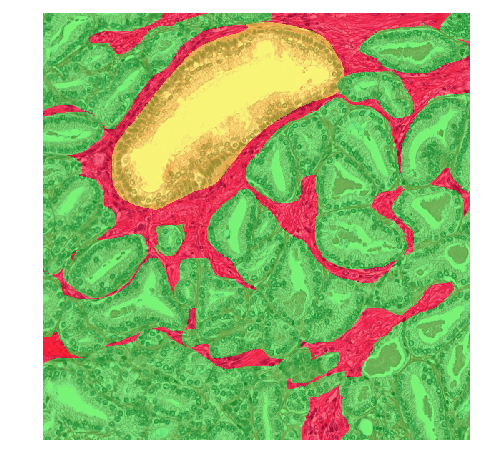

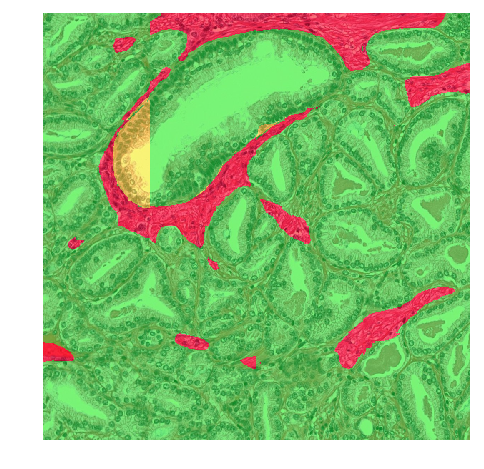

In [26]:
# Visualization the sementic map
visualize.display_sementic(img, ann,
                            figsize=(8, 8))
visualize.display_sementic(img, det,
                            figsize=(8, 8))

## Evaluation

In [31]:
c_matrix = confusion_matrix(np.ravel(ann), np.ravel(det))
c_matrix = utils.expand_c_matrix(c_matrix, detection_config.NUM_CLASSES, ann, det)
mIOU, IOU, below_th = utils.compute_mIOU(c_matrix, th = 0.5)
print('Confusion Matrix:\n', c_matrix)
print(' mIOU:', mIOU, '\n', 
      'IOU for each class:', IOU, '\n',
      'Below_th:', below_th)

Confusion Matrix:
 [[  92359.   91138.       0.    1762.]
 [  16540.  711227.       0.       0.]
 [      0.       0.       0.       0.]
 [   4804.  114668.       0.   16078.]]
 mIOU: 0.331490102037 
 IOU for each class: [0.44703610305755481, 0.76183330066315114, 0, 0.11709100442787229] 
 Below_th: True


## Save Probability Map 

In [28]:
prob_map_dict = {'prob_mask': prob}
file_name = "probs_map/" + str(val_list[0]).zfill(4) + '_sementic_probs.mat'
file_path = os.path.join(dataset_dir, file_name)
utils.save_sementic(file_path, prob_map_dict)